DATASET DOWNLOAD AND EXTRACT

In [3]:
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from utility import plot_confusion_matrix
import tensorflow.keras.layers as layer
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [4]:
seed = 1231829
tf.random.set_seed(seed)
np.random.seed(seed)

In [14]:
from data_loader import get_data
X_data, labels = get_data()

/Users/denisderonjic/Repos/ActivityRecognition/data_loader.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (np.array(X_data), labels)


In [15]:
print(X_data.shape)
print(labels.shape)

(761,)
(761,)


FALLING


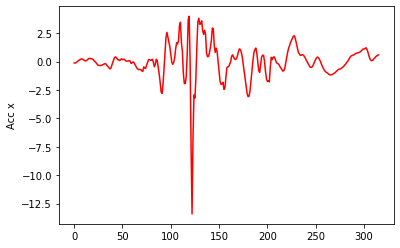

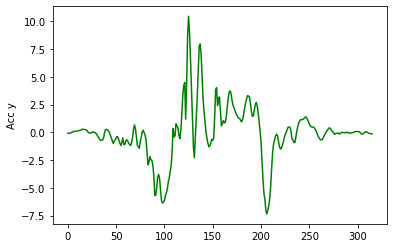

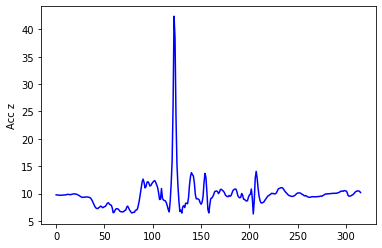

In [16]:
import matplotlib.pyplot as plt

measure = 10
print(labels[measure])
accX = X_data[measure][:, 0]
#accX = np.fft.fft(accX)
plt.plot(accX, color='r')
plt.ylabel('Acc x')
plt.show()

accY = X_data[measure][:, 1]
#accY = np.fft.fft(accY)
plt.plot(accY, color='g')
plt.ylabel('Acc y')
plt.show()

accZ = X_data[measure][:, 2]
#accZ = np.fft.fft(accZ)
plt.plot(accZ, color='b')
plt.ylabel('Acc z')
plt.show()
del accX, accY, accZ

In [17]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

labels = le.fit_transform(labels)

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

num_labels = len(le_name_mapping)
print(num_labels)

{'FALLING': 0, 'JUMPING': 1, 'RUNNING': 2, 'SITTING': 3, 'STNDING': 4, 'WALKING': 5, 'XLYINGX': 6}
7


In [19]:
from data_transformation import frame_data

X_data, y_data = frame_data(X_data, labels)

In [20]:
X_data = X_data[:,:, :6] #Dropping magnetometer

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=seed)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
#check https://stackoverflow.com/questions/59979763/cant-get-done-conv1d-with-tf-keras
#check https://stats.stackexchange.com/questions/264546/difference-between-samples-time-steps-and-features-in-neural-network
print(X_train.shape)
print(y_train.shape)

(148995, 128, 6)
(148995,)


In [23]:
#data normalization
normalization = tf.keras.layers.experimental.preprocessing.Normalization()
normalization.adapt(X_train)
X_train_norm = normalization(X_train)
normalization.adapt(X_test)
X_test_norm = normalization(X_test)

# Convolutional Autoencoder

In [25]:
batch_size = 56
dataset = tf.data.Dataset.from_tensor_slices((X_train[:10], y_train[:10])).shuffle(10000).batch(batch_size)

In [31]:
from models import Encoder, Decoder
encoded_space_dim = 64
encoder = Encoder(encoded_space_dim)
decoder = Decoder()

for (sig, label) in dataset:
  #sig = tf.transpose(sig, [0, 2, 1])
  
  print(sig.shape)
  x = encoder(sig)
  x = decoder(x)
  print(x.shape)
  break

(10, 128, 6)
(10, 128, 6)


In [32]:
autoencoder = tf.keras.models.Sequential([encoder, decoder])
output = autoencoder(X_train[:1])
#compute_loss(autoencoder, X_train[:1])
print(output.shape)

(1, 128, 6)


In [33]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          (1, 64)                   150560    
_________________________________________________________________
decoder_2 (Decoder)          (1, 128, 6)               150726    
Total params: 301,286
Trainable params: 301,286
Non-trainable params: 0
_________________________________________________________________


In [34]:
encoder.summary()

Model: "encoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          multiple                  0 (unused)
_________________________________________________________________
conv1d_8 (Conv1D)            multiple                  4864      
_________________________________________________________________
conv1d_9 (Conv1D)            multiple                  98432     
_________________________________________________________________
conv1d_10 (Conv1D)           multiple                  24640     
_________________________________________________________________
conv1d_11 (Conv1D)           multiple                  6176      
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  16

In [35]:
decoder.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  16640     
_________________________________________________________________
reshape_2 (Reshape)          multiple                  0         
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr multiple                  6208      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr multiple                  24704     
_________________________________________________________________
conv1d_transpose_10 (Conv1DT multiple                  98560     
_________________________________________________________________
conv1d_transpose_11 (Conv1DT multiple                  4614      
Total params: 150,726
Trainable params: 150,726
Non-trainable params: 0
___________________________________________________

In [40]:
loss_object = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam()

encoded_space_dim = 256
encoder = Encoder(encoded_space_dim)
decoder = Decoder()
autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.compile(optimizer=optimizer, loss=loss_object)

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = autoencoder.fit(X_train_norm, X_train_norm,
                epochs=10,
                shuffle=True,
                batch_size=64,
                validation_split=0.2,
                callbacks=[callback])

Epoch 1/10
1863/1863 [==============================] - 48s 26ms/step - loss: 0.5713 - val_loss: 0.4136
Epoch 2/10
1863/1863 [==============================] - 48s 26ms/step - loss: 0.3748 - val_loss: 0.3225
Epoch 3/10
1863/1863 [==============================] - 48s 26ms/step - loss: 0.3136 - val_loss: 0.2937
Epoch 4/10
1863/1863 [==============================] - 49s 26ms/step - loss: 0.2779 - val_loss: 0.2519
Epoch 5/10
1863/1863 [==============================] - 56s 30ms/step - loss: 0.2523 - val_loss: 0.2407
Epoch 6/10
1863/1863 [==============================] - 49s 26ms/step - loss: 0.2331 - val_loss: 0.2257
Epoch 7/10
1863/1863 [==============================] - 49s 26ms/step - loss: 0.2200 - val_loss: 0.2142
Epoch 8/10
1863/1863 [==============================] - 49s 26ms/step - loss: 0.2090 - val_loss: 0.2223
Epoch 9/10
1838/1863 [============================>.] - ETA: 0s - loss: 0.2006

In [39]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

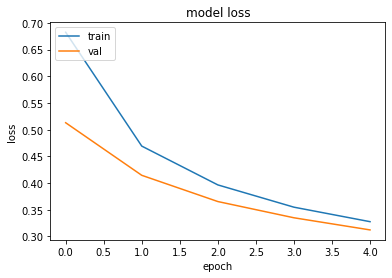

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
X_trans = autoencoder(X_test_norm[:1000])


Text(0.5, 1.0, 'Pred Acc 1')

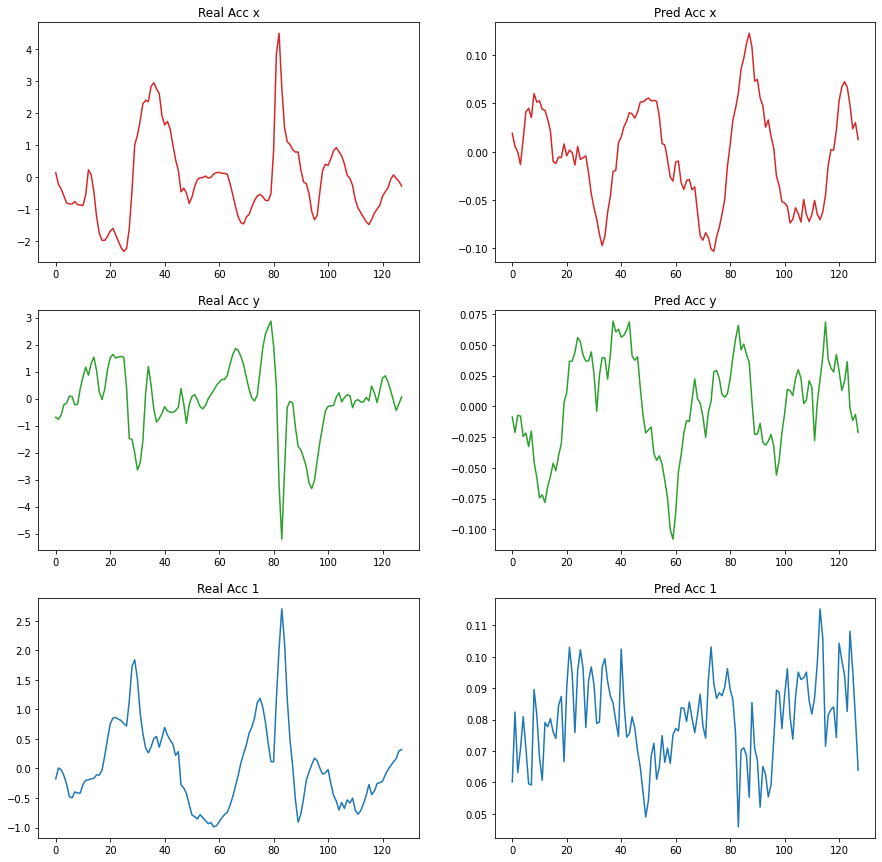

In [42]:
measure = 0
fig, axs = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0, 0].plot(X_train_norm[measure,:,0], 'tab:red')
axs[0, 0].set_title('Real Acc x')
axs[0, 1].plot(X_trans[measure,:,0], 'tab:red')
axs[0, 1].set_title('Pred Acc x')

axs[1, 0].plot(X_train_norm[measure,:,1], 'tab:green')
axs[1, 0].set_title('Real Acc y')
axs[1, 1].plot(X_trans[measure,:,1], 'tab:green')
axs[1, 1].set_title('Pred Acc y')

axs[2, 0].plot(X_train_norm[measure,:,2], 'tab:blue')
axs[2, 0].set_title('Real Acc 1')
axs[2, 1].plot(X_trans[measure,:,2], 'tab:blue')
axs[2, 1].set_title('Pred Acc 1')






In [43]:
### Get the encoded representation of the test samples
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test)).shuffle(10000).batch(1000)
encoded_samples = []
labels = []
for sample, label in test_dataset:
    output = encoder(sample)
    # Append to list
    encoded = output.numpy()
    for i in range(len(encoded)):
      enc = encoded[i]
      lbl = label[i]
      encoded_samples.append(enc)
      labels.append(lbl)
    if len(encoded_samples) % 10000 == 0:
      break

In [44]:
print(np.array(encoded_samples).shape)

(10000, 128)


In [44]:
from sklearn import manifold
tsne = manifold.TSNE(2, init='pca', random_state=0).fit_transform(encoded_samples)

In [57]:
#import plotly.express as px
#px.scatter(x=tsne[:, 0], y=tsne[:, 1], color=labels, opacity=0.7)

In [ ]:
from sklearn.svm import SVC

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train)).shuffle(10000).batch(1000)
encoded_train = []
labels = []
for sample, label in train_dataset:
    output = encoder(sample)
    
    encoded = output.numpy()
    for i in range(len(encoded)):
      enc = encoded[i]
      lbl = label[i]
      encoded_train.append(enc)
      labels.append(lbl)
encoded_train = np.array(encoded_train)
labels = np.array(labels)

In [ ]:
print(encoded_train.shape)

(152476, 128)


In [ ]:
svc = SVC(gamma='auto', verbose=True)

In [ ]:
#svc.fit(encoded_train, labels)

In [48]:
linear =  tf.keras.models.Sequential([layer.Dense(32, activation='relu'), layer.Dense(num_labels, activation='softmax')])
model = tf.keras.models.Sequential([encoder, linear])
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss_function, metrics=['acc'])

In [49]:
print(X_train.shape)
print(y_train.shape)

(148995, 128, 6)
(148995,)


In [50]:
history = model.fit(X_train_norm, y_train,
                epochs=10,
                shuffle=True,
                batch_size=64,
                validation_split=0.2)

Epoch 1/10
1863/1863 [==============================] - 20s 11ms/step - loss: 0.4254 - acc: 0.8376 - val_loss: 0.3838 - val_acc: 0.8500
Epoch 2/10
1863/1863 [==============================] - 20s 11ms/step - loss: 0.3125 - acc: 0.8815 - val_loss: 0.3025 - val_acc: 0.8850
Epoch 3/10
1863/1863 [==============================] - 20s 11ms/step - loss: 0.2565 - acc: 0.9037 - val_loss: 0.2308 - val_acc: 0.9155
Epoch 4/10
1863/1863 [==============================] - 20s 11ms/step - loss: 0.2154 - acc: 0.9205 - val_loss: 0.2299 - val_acc: 0.9123
Epoch 5/10
1863/1863 [==============================] - 20s 11ms/step - loss: 0.1781 - acc: 0.9345 - val_loss: 0.1969 - val_acc: 0.9267
Epoch 6/10
1863/1863 [==============================] - 20s 10ms/step - loss: 0.1522 - acc: 0.9437 - val_loss: 0.1513 - val_acc: 0.9437
Epoch 7/10
1863/1863 [==============================] - 20s 11ms/step - loss: 0.1283 - acc: 0.9538 - val_loss: 0.1408 - val_acc: 0.9487
Epoch 8/10
1863/1863 [==========================

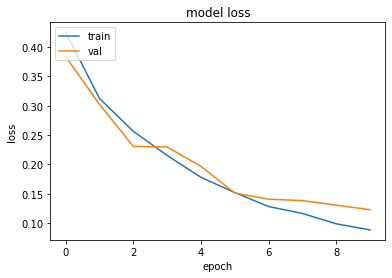

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test)).shuffle(10000).batch(1000)
tot_acc = []
for (data, label) in test_dataset:

  y_pred = np.argmax(model(data), axis=1)
  matrix = confusion_matrix(label, y_pred)
  accuracy = np.trace(matrix) / np.sum(matrix)
  tot_acc.append(accuracy)
print(np.mean(tot_acc))

0.9305252765719085


In [53]:
pred = np.argmax(model(X_test_norm[:100]), axis=1)
print(le.inverse_transform(pred))

['SITTING' 'STNDING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'SITTING' 'SITTING' 'SITTING'
 'SITTING' 'WALKING' 'WALKING' 'SITTING' 'WALKING' 'WALKING' 'STNDING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'WALKING' 'WALKING' 'WALKING'
 'STNDING' 'SITTING' 'WALKING' 'STNDING' 'STNDING' 'RUNNING' 'RUNNING'
 'WALKING' 'STNDING' 'STNDING' 'SITTING' 'SITTING' 'WALKING' 'SITTING'
 'XLYINGX' 'WALKING' 'STNDING' 'WALKING' 'RUNNING' 'SITTING' 'STNDING'
 'STNDING' 'RUNNING' 'STNDING' 'WALKING' 'STNDING' 'STNDING' 'SITTING'
 'WALKING' 'STNDING' 'RUNNING' 'STNDING' 'STNDING' 'XLYINGX' 'STNDING'
 'XLYINGX' 'XLYINGX' 'STNDING' 'XLYINGX' 'STNDING' 'STNDING' 'XLYINGX'
 'XLYINGX' 'XLYINGX' 'SITTING' 'WALKING' 'STNDING' 'XLYINGX' 'WALKING'
 'XLYINGX' 'WALKING' 'WALKING' 'XLYINGX' 'STNDING' 'STNDING' 'SITTING'
 'SITTING' 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'STNDING' 'STNDING'
 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'RUNNING' 'SITTING' 'SITTING'
 'STND

In [54]:
print(le.inverse_transform(y_test[:100]))

['SITTING' 'STNDING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'STNDING' 'SITTING' 'XLYINGX'
 'SITTING' 'WALKING' 'WALKING' 'SITTING' 'WALKING' 'WALKING' 'STNDING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'WALKING' 'WALKING' 'WALKING'
 'STNDING' 'SITTING' 'WALKING' 'STNDING' 'STNDING' 'RUNNING' 'RUNNING'
 'WALKING' 'STNDING' 'STNDING' 'SITTING' 'SITTING' 'WALKING' 'SITTING'
 'XLYINGX' 'STNDING' 'STNDING' 'WALKING' 'RUNNING' 'STNDING' 'STNDING'
 'STNDING' 'RUNNING' 'STNDING' 'WALKING' 'STNDING' 'STNDING' 'STNDING'
 'WALKING' 'STNDING' 'RUNNING' 'STNDING' 'STNDING' 'XLYINGX' 'STNDING'
 'XLYINGX' 'XLYINGX' 'STNDING' 'XLYINGX' 'STNDING' 'STNDING' 'XLYINGX'
 'XLYINGX' 'XLYINGX' 'SITTING' 'WALKING' 'STNDING' 'XLYINGX' 'WALKING'
 'XLYINGX' 'WALKING' 'WALKING' 'XLYINGX' 'STNDING' 'STNDING' 'SITTING'
 'SITTING' 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'STNDING' 'STNDING'
 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'RUNNING' 'SITTING' 'SITTING'
 'STND

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppan6mdm7/assets


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test)).shuffle(10000).batch(1000)
encoded_samples = []
labels = []
for sample, label in test_dataset:
    output = encoder(sample)
    # Append to list
    encoded = output.numpy()
    for i in range(len(encoded)):
      enc = encoded[i]
      lbl = label[i]
      encoded_samples.append(enc)
      labels.append(lbl)
    if len(encoded_samples) % 10000 == 0:
      break

In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(2, init='pca', random_state=0).fit_transform(encoded_samples)

In [ ]:
import plotly.express as px
px.scatter(x=tsne[:, 0], y=tsne[:, 1], color=labels, opacity=0.7)

# Classification NN

In [35]:
from models import ConvolutionalClassificationNN
  

model = ConvolutionalClassificationNN(num_labels)

model_test_data = X_train_norm[0:10, :, :]
x = model(model_test_data)
print(x.shape)

(10, 7)


In [56]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (10, 128, 256)            14080     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (10, 64, 256)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (10, 64, 128)             229504    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (10, 32, 128)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (10, 32, 64)              41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (10, 16, 64)              0         
_________________________________________________________________
conv1d_16 (Conv1D)           (10, 16, 32)             

In [57]:
print(X_train_norm.shape)
print(y_train.shape)

(148995, 128, 6)
(148995,)


In [58]:
from sklearn.utils import class_weight

class_weights_list = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights = {}
for i in range(num_labels):
  w = class_weights_list[i]
  class_weights[i] = w
print(class_weights)

{0: 22.547669491525422, 1: 5.74338909875877, 2: 2.829699547992555, 3: 0.7315438548254055, 4: 0.35958643758552533, 5: 0.6103575832305795, 6: 1.5580850596588829}


/Users/denisderonjic/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[5 0 4 ... 0 3 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [60]:
#from focal_loss import SparseCategoricalFocalLoss

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#loss_object = SparseCategoricalFocalLoss(gamma=2.0)
optimizer = tf.keras.optimizers.Adam()

classificationModel = ConvolutionalClassificationNN(num_labels)
classificationModel.compile(optimizer=optimizer, loss=loss_object, metrics=['acc'])


In [61]:
callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5)
history = classificationModel.fit(X_train_norm, y_train,
                epochs=20,
                shuffle=True,
                batch_size=64,
                validation_split=0.2,
                #class_weight=class_weights,
                callbacks=[callback])

Epoch 1/20
1863/1863 [==============================] - 65s 35ms/step - loss: 0.7188 - acc: 0.7204 - val_loss: 0.5350 - val_acc: 0.7882
Epoch 2/20
1863/1863 [==============================] - 62s 33ms/step - loss: 0.4408 - acc: 0.8356 - val_loss: 0.3151 - val_acc: 0.8868
Epoch 3/20
1081/1863 [================>.............] - ETA: 24s - loss: 0.3224 - acc: 0.8834

KeyboardInterrupt: 

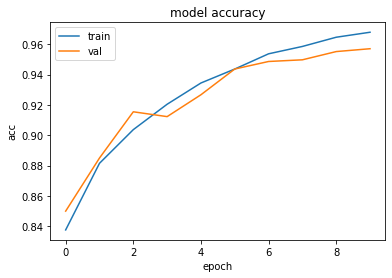

In [62]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test)).batch(1000)
tot_acc = []
y_pred_tot = []
for (data, label) in test_dataset:
  output = classificationModel(data)
  y_pred = np.argmax(output, axis=1)
  for pred in y_pred:
    y_pred_tot.append(pred)
  matrix = confusion_matrix(label, y_pred)
  accuracy = np.trace(matrix) / np.sum(matrix)
  tot_acc.append(accuracy)
print(np.mean(tot_acc))

0.8888889511272932


In [64]:
pred = np.argmax(classificationModel(X_test_norm[:100]), axis=1)
print(le.inverse_transform(pred))

['XLYINGX' 'STNDING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'XLYINGX' 'SITTING' 'SITTING'
 'SITTING' 'WALKING' 'WALKING' 'SITTING' 'WALKING' 'WALKING' 'STNDING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'WALKING' 'WALKING' 'WALKING'
 'STNDING' 'SITTING' 'WALKING' 'STNDING' 'STNDING' 'RUNNING' 'RUNNING'
 'WALKING' 'STNDING' 'STNDING' 'SITTING' 'SITTING' 'WALKING' 'SITTING'
 'XLYINGX' 'XLYINGX' 'STNDING' 'WALKING' 'RUNNING' 'SITTING' 'STNDING'
 'STNDING' 'RUNNING' 'STNDING' 'WALKING' 'STNDING' 'SITTING' 'STNDING'
 'WALKING' 'STNDING' 'RUNNING' 'STNDING' 'SITTING' 'XLYINGX' 'XLYINGX'
 'XLYINGX' 'XLYINGX' 'STNDING' 'SITTING' 'STNDING' 'STNDING' 'XLYINGX'
 'XLYINGX' 'XLYINGX' 'SITTING' 'WALKING' 'STNDING' 'XLYINGX' 'WALKING'
 'XLYINGX' 'WALKING' 'WALKING' 'XLYINGX' 'STNDING' 'STNDING' 'SITTING'
 'XLYINGX' 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'STNDING' 'STNDING'
 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'RUNNING' 'XLYINGX' 'SITTING'
 'STND

In [65]:
print(le.inverse_transform(y_test[:100]))

['SITTING' 'STNDING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'STNDING' 'SITTING' 'XLYINGX'
 'SITTING' 'WALKING' 'WALKING' 'SITTING' 'WALKING' 'WALKING' 'STNDING'
 'STNDING' 'WALKING' 'STNDING' 'WALKING' 'WALKING' 'WALKING' 'WALKING'
 'STNDING' 'SITTING' 'WALKING' 'STNDING' 'STNDING' 'RUNNING' 'RUNNING'
 'WALKING' 'STNDING' 'STNDING' 'SITTING' 'SITTING' 'WALKING' 'SITTING'
 'XLYINGX' 'STNDING' 'STNDING' 'WALKING' 'RUNNING' 'STNDING' 'STNDING'
 'STNDING' 'RUNNING' 'STNDING' 'WALKING' 'STNDING' 'STNDING' 'STNDING'
 'WALKING' 'STNDING' 'RUNNING' 'STNDING' 'STNDING' 'XLYINGX' 'STNDING'
 'XLYINGX' 'XLYINGX' 'STNDING' 'XLYINGX' 'STNDING' 'STNDING' 'XLYINGX'
 'XLYINGX' 'XLYINGX' 'SITTING' 'WALKING' 'STNDING' 'XLYINGX' 'WALKING'
 'XLYINGX' 'WALKING' 'WALKING' 'XLYINGX' 'STNDING' 'STNDING' 'SITTING'
 'SITTING' 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'STNDING' 'STNDING'
 'STNDING' 'RUNNING' 'WALKING' 'WALKING' 'RUNNING' 'SITTING' 'SITTING'
 'STND

In [66]:
from sklearn.metrics import precision_score, recall_score

#None, 'micro', 'macro', 'weighted'
print("Precision score: ", precision_score(y_test, y_pred_tot, average='macro'))
print("Recall score: ", recall_score(y_test, y_pred_tot, average='macro'))

Precision score:  0.8737581411085945
Recall score:  0.8326557541333213


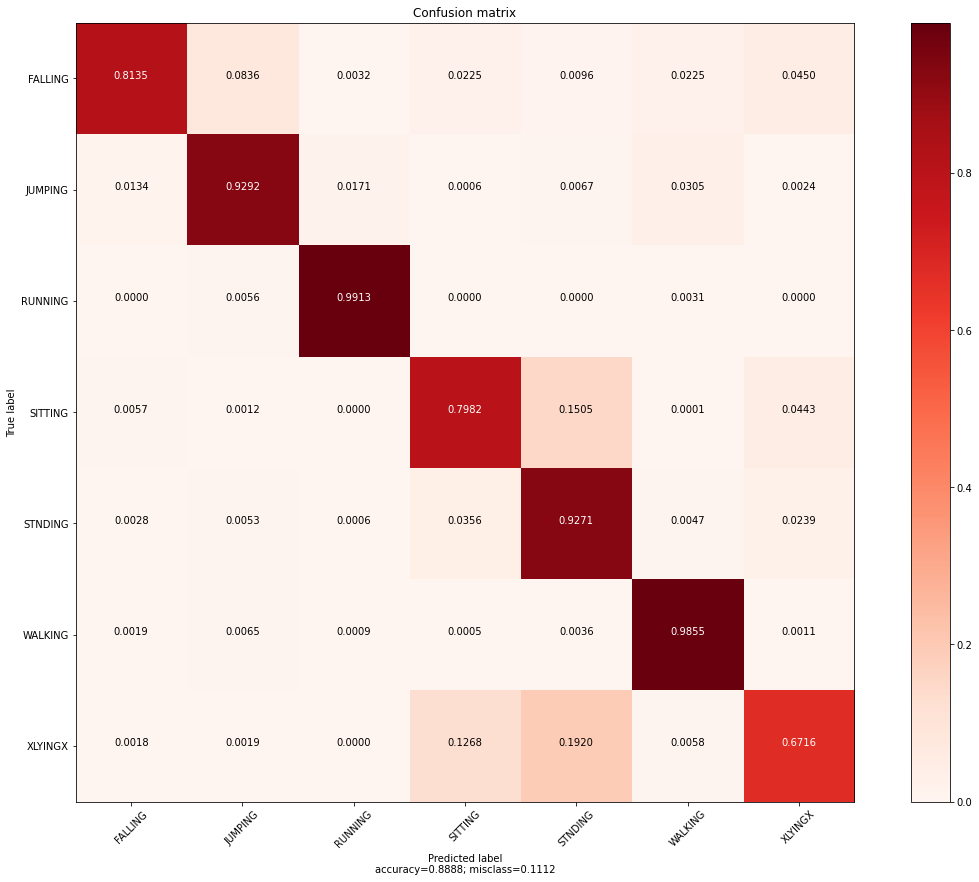

In [67]:
plot_confusion_matrix(y_pred_tot, y_test, target_names=le.classes_)

# Classification On FFT data

In [ ]:
X_train_fft = np.fft.fft(X_train, axis=1)
X_test_fft = np.fft.fft(X_test, axis=1)

print(X_train.shape)
print(X_train_fft.shape)

(148995, 128, 6)
(148995, 128, 6)


(128,)


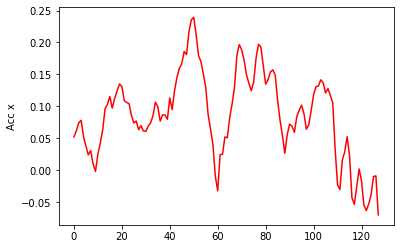

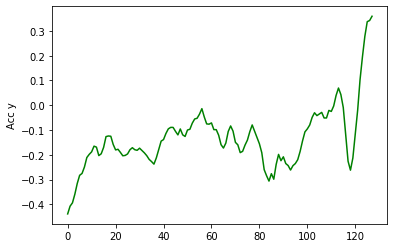

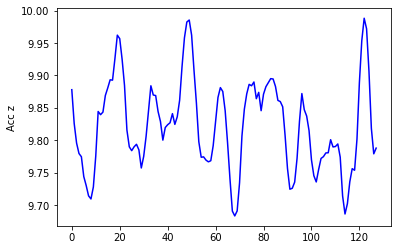

In [ ]:
measure = 12
accX = X_train[measure,:,0]
print(accX.shape)
#accX = np.fft.fft(accX)
plt.plot(accX, color='r')
plt.ylabel('Acc x')
plt.show()

accY = X_train[measure,:,1]
#accY = np.fft.fft(accY)
plt.plot(accY, color='g')
plt.ylabel('Acc y')
plt.show()

accZ = X_train[measure,:,2]
#accZ = np.fft.fft(accZ)
plt.plot(accZ, color='b')
plt.ylabel('Acc z')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


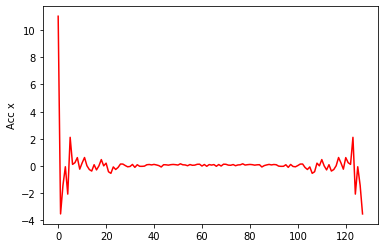

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


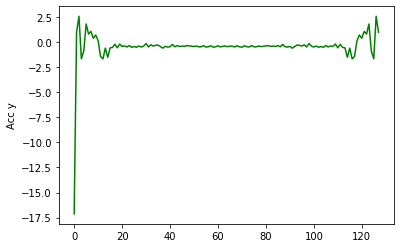

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


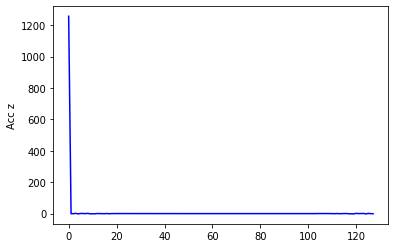

In [ ]:
accX = X_train_fft[measure,:,0]
plt.plot(accX, color='r')
plt.ylabel('Acc x')
plt.show()

accY = X_train_fft[measure,:,1]
plt.plot(accY, color='g')
plt.ylabel('Acc y')
plt.show()

accZ = X_train_fft[measure,:,2]
#accZ = tf.signal.fft(accZ)
plt.plot(accZ, color='b')
plt.ylabel('Acc z')
plt.show()

In [ ]:
normalization = tf.keras.layers.experimental.preprocessing.Normalization()
normalization.adapt(X_train_fft)
X_train_norm_fft = normalization(X_train_fft)
normalization = tf.keras.layers.experimental.preprocessing.Normalization()
normalization.adapt(X_test_fft)
X_test_norm = normalization(X_test_fft)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

classificationModel_fft = ConvolutionalClassificationNN(num_labels)
classificationModel_fft.compile(optimizer=optimizer, loss=loss_object, metrics=['acc'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5)
history = classificationModel_fft.fit(X_train_norm_fft, y_train,
                epochs=20,
                shuffle=True,
                batch_size=64,
                validation_split=0.2,
                callbacks=[callback])

Epoch 1/20
1863/1863 [==============================] - 24s 12ms/step - loss: 0.7596 - acc: 0.7037 - val_loss: 0.5959 - val_acc: 0.7716
Epoch 2/20
1863/1863 [==============================] - 22s 12ms/step - loss: 0.5767 - acc: 0.7845 - val_loss: 0.5102 - val_acc: 0.7988
Epoch 3/20
1863/1863 [==============================] - 23s 12ms/step - loss: 0.4873 - acc: 0.8191 - val_loss: 0.4296 - val_acc: 0.8364
Epoch 4/20
1863/1863 [==============================] - 22s 12ms/step - loss: 0.4317 - acc: 0.8417 - val_loss: 0.4080 - val_acc: 0.8492
Epoch 5/20
1863/1863 [==============================] - 22s 12ms/step - loss: 0.3953 - acc: 0.8556 - val_loss: 0.3797 - val_acc: 0.8575
Epoch 6/20
1863/1863 [==============================] - 22s 12ms/step - loss: 0.3669 - acc: 0.8656 - val_loss: 0.3773 - val_acc: 0.8582
Epoch 7/20
1863/1863 [==============================] - 22s 12ms/step - loss: 0.3454 - acc: 0.8730 - val_loss: 0.3709 - val_acc: 0.8608
Epoch 8/20
1863/1863 [==========================

# Classification On Vector norm of accelerometer data

In [ ]:
X_train_mag = X_train[:, :, 0:3]
X_train_mag = np.linalg.norm(X_train_mag, axis=2, keepdims=True)
X_test_mag = X_test[:,:,0:3]
X_test_mag = np.linalg.norm(X_test_mag, axis=2, keepdims=True)

(128, 1)


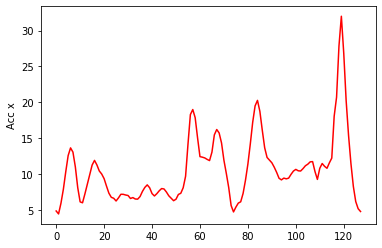

In [ ]:
measure = 1
accX = X_train_mag[measure,:]
print(accX.shape)
#accX = np.fft.fft(accX)
plt.plot(accX, color='r')
plt.ylabel('Acc x')
plt.show()

In [ ]:
normalization = tf.keras.layers.experimental.preprocessing.Normalization()
normalization.adapt(X_train_mag)
X_train_norm_mag = normalization(X_train_mag)
normalization = tf.keras.layers.experimental.preprocessing.Normalization()
normalization.adapt(X_test_mag)
X_test_norm_mag = normalization(X_test_mag)

In [ ]:
def MagnitudeClassificationModelNN(num_labels):
    
    return tf.keras.models.Sequential(
        [
          layer.Conv1D(filters=64, kernel_size=5, strides=1, padding='same'),
          layer.ReLU(),
          layer.MaxPooling1D(pool_size=2, strides=2, padding='same'),
         
          layer.Conv1D(filters=64, kernel_size=5, strides=1, padding='same'),
          layer.ReLU(),
          layer.MaxPooling1D(pool_size=2, strides=2, padding='same'),
          
          layer.Conv1D(filters=64, kernel_size=3, strides=1, padding='same'),
          layer.ReLU(),
          layer.MaxPooling1D(pool_size=2, strides=2, padding='same'),
          
          layer.Conv1D(filters=64, kernel_size=3, strides=1, padding='same'),
          layer.ReLU(),
          layer.MaxPooling1D(pool_size=2, strides=2, padding='same'),
         
          layer.Flatten(),
          layer.Dropout(0.5),
          layer.Dense(num_labels, activation='softmax'),
        ]
    )
  
class MagnitudeClassificationModelNN2(Model):
  def __init__(self, num_labels):
    super(MagnitudeClassificationModelNN2, self).__init__()
    self.conv1 = layer.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='valid')
    self.conv2 = layer.Conv1D(filters=128, kernel_size=4, strides=1, activation='relu', padding='valid')
    self.conv3 = layer.Conv1D(filters=128, kernel_size=5, strides=1, activation='relu', padding='valid')
    self.maxPooling1 = layer.MaxPooling1D(126)
    self.maxPooling2 = layer.MaxPooling1D(125)
    self.maxPooling3 = layer.MaxPooling1D(124)
    self.dropout = layer.Dropout(0.5)
    self.dense = layer.Dense(384*384*3)
    self.outputLayer = layer.Dense(num_labels, activation='softmax')
  
  def call(self, x):
    x1 = self.conv1(x)
    x1 = self.maxPooling1(x1)
    #print(x1.shape)
    x2 = self.conv2(x)
    x2 = self.maxPooling2(x2)
    #print(x2.shape)
    x3 = self.conv3(x)
    x3 = self.maxPooling3(x3)
    #print(x3.shape)
    x = tf.concat([x1, x2, x3], axis=2)
    #print(x.shape)
    x = self.dropout(x)
    x = self.dense(x)
    #print(x.shape)
    x = self.outputLayer(x)
    return x
model = MagnitudeClassificationModelNN(num_labels)

model_test_data = X_train_norm[0:10, :, :]
x = model(model_test_data)
print(x.shape)

(10, 7)


In [ ]:
from focal_loss import SparseCategoricalFocalLoss

#loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
loss_object = SparseCategoricalFocalLoss(gamma=5.0)
optimizer = tf.keras.optimizers.Adam()

classificationModel = MagnitudeClassificationModelNN(num_labels)
classificationModel.compile(optimizer=optimizer, loss=loss_object, metrics=['acc'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5)
history = classificationModel.fit(X_train_norm_mag, y_train,
                epochs=20,
                shuffle=True,
                batch_size=64,
                validation_split=0.2,
                callbacks=[callback])

Epoch 1/20
1863/1863 [==============================] - 16s 8ms/step - loss: 0.7639 - acc: 0.6806 - val_loss: 0.7067 - val_acc: 0.6903
Epoch 2/20
1863/1863 [==============================] - 13s 7ms/step - loss: 0.6838 - acc: 0.7098 - val_loss: 0.6470 - val_acc: 0.7228
Epoch 3/20
1863/1863 [==============================] - 14s 8ms/step - loss: 0.6491 - acc: 0.7245 - val_loss: 0.6301 - val_acc: 0.7297
Epoch 4/20
1863/1863 [==============================] - 14s 8ms/step - loss: 0.6325 - acc: 0.7296 - val_loss: 0.6080 - val_acc: 0.7364
Epoch 5/20
1863/1863 [==============================] - 14s 8ms/step - loss: 0.6160 - acc: 0.7364 - val_loss: 0.5988 - val_acc: 0.7415
Epoch 6/20
1863/1863 [==============================] - 14s 8ms/step - loss: 0.5991 - acc: 0.7462 - val_loss: 0.5887 - val_acc: 0.7447
Epoch 7/20
1863/1863 [==============================] - 14s 8ms/step - loss: 0.5853 - acc: 0.7542 - val_loss: 0.5697 - val_acc: 0.7557
Epoch 8/20
1863/1863 [==============================] -

In [ ]:
from sklearn.metrics import confusion_matrix

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm_mag, y_test)).batch(1000)
tot_acc = []
y_pred_tot = []
for (data, label) in test_dataset:
  output = classificationModel(data)
  y_pred = np.argmax(output, axis=1)
  for pred in y_pred:
    y_pred_tot.append(pred)
  matrix = confusion_matrix(label, y_pred)
  accuracy = np.trace(matrix) / np.sum(matrix)
  tot_acc.append(accuracy)
print(np.mean(tot_acc))

0.7365163142417028


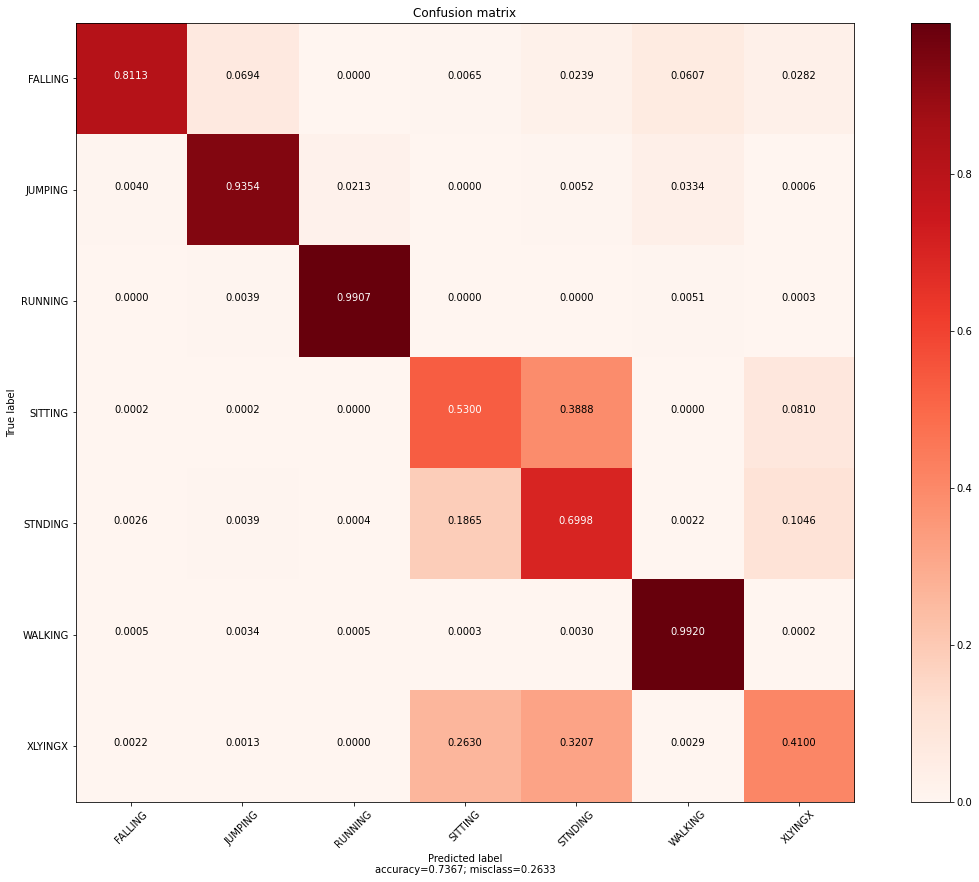

In [ ]:
plot_confusion_matrix(y_pred_tot, y_test, target_names=le.classes_)

# Recurrent Auto Encoder

In [ ]:
prova_data = X_train_norm[0:10, :, :]
lstm = layer.LSTM(100, input_shape=(128, 6))
rep = layer.RepeatVector(128)
lstm1 = layer.LSTM(10, return_sequences=False)
output = lstm(prova_data)
output = rep(output)
#output = lstm1(output)
print(output.shape)

(10, 128, 100)


In [ ]:
batch_size = 56
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)

In [ ]:
class RNNEncoder(Model):
  def __init__(self, encoded_space_dim):
    super(RNNEncoder, self).__init__()
    self.rnn1 = layer.LSTM(3, return_sequences=True)
    self.rnn2 = layer.LSTM(1, return_sequences=True)
    self.flatten = layer.Flatten()
    self.d2 = layer.Dense(encoded_space_dim, activation='relu')
  
  def call(self, x):
    x = self.rnn1(x)
    x = self.rnn2(x)
    x = self.flatten(x)
    x = self.d2(x)
    return x

class RNNDecoder(Model):
  def __init__(self):
    super(RNNDecoder, self).__init__()
    self.d1 = layer.Dense(1 * 128, activation='relu')
    self.reshape = layer.Reshape((128, 1))
    self.rnn1 = layer.LSTM(3, return_sequences=True)
    self.rnn2 = layer.LSTM(6, return_sequences=True)

  def call(self, x):
    x = self.d1(x)
    x = self.reshape(x)
    x = self.rnn1(x)
    x = self.rnn2(x)

    return x

encoded_space_dim = 64
encoder = RNNEncoder(encoded_space_dim)
decoder = RNNDecoder()

model_test_data = X_train_norm[0:10, :, :]
x = encoder(model_test_data)
x = decoder(x)
print(x.shape)

#for (sig, label) in dataset:
  #sig = tf.transpose(sig, [0, 2, 1])
  
  #print(sig.shape)
  #x = encoder(sig)
  #x = decoder(x)
  #print(x.shape)
  #break

(10, 128, 6)


In [ ]:
loss_object = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam()

encoded_space_dim = 64
encoder = RNNEncoder(encoded_space_dim)
decoder = RNNDecoder()
rnnAutoencoder = tf.keras.models.Sequential([encoder, decoder])
rnnAutoencoder.compile(optimizer='adam', loss=loss_object)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = rnnAutoencoder.fit(X_train_norm, X_train_norm,
                epochs=10,
                shuffle=True,
                batch_size=256,
                validation_split=0.2,
                callbacks=[callback])

Epoch 1/10
 24/477 [>.............................] - ETA: 2:17 - loss: 1.0209

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_trans = rnnAutoencoder(X_test_norm[:1000])

In [ ]:
measure = 967
fig, axs = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0, 0].plot(X_train_norm[measure,:,0], 'tab:red')
axs[0, 0].set_title('Real Acc x')
axs[0, 1].plot(X_trans[measure,:,0], 'tab:red')
axs[0, 1].set_title('Pred Acc x')

axs[1, 0].plot(X_train_norm[measure,:,1], 'tab:green')
axs[1, 0].set_title('Real Acc y')
axs[1, 1].plot(X_trans[measure,:,1], 'tab:green')
axs[1, 1].set_title('Pred Acc y')

axs[2, 0].plot(X_train_norm[measure,:,2], 'tab:blue')
axs[2, 0].set_title('Real Acc 1')
axs[2, 1].plot(X_trans[measure,:,2], 'tab:blue')
axs[2, 1].set_title('Pred Acc 1')

In [ ]:
### Get the encoded representation of the test samples
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test)).shuffle(10000).batch(1000)
encoded_samples = []
labels = []
for sample, label in test_dataset:
    output = encoder(sample)
    # Append to list
    encoded = output.numpy()
    for i in range(len(encoded)):
      enc = encoded[i]
      lbl = label[i]
      encoded_samples.append(enc)
      labels.append(lbl)
    if len(encoded_samples) % 10000 == 0:
      break

In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(2, init='pca', random_state=0).fit_transform(encoded_samples)

In [ ]:
import plotly.express as px
px.scatter(x=tsne[:, 0], y=tsne[:, 1], color=labels, opacity=0.7)